In [344]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import invwishart 
from scipy.stats import invgamma
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.chdir(r'C:\Users\davme\Documents\Università Bocconi\DSBA\Curricular Courses 20222023\STATISTICS AND PROBABILITY\Computational Statistics Module\Final Project\Final Project\Assignment Content')

# read data with covariates
df = pd.read_csv('Scores_with_covariates.csv',sep=" ")

#add column of ones, so we can easily add an intercept to the regressions (adding an intercept is the same as using a column of ones in X)
df["intercept"] = 1

df

,sch_id,sch_freelunch,stu_ses,stu_mathscore,intercept
0,1011,6,-0.059948,52.11,1
1,1011,6,1.051652,57.65,1
2,1011,6,-0.863515,66.44,1
3,1011,6,-0.796551,44.68,1
4,1011,6,-1.613511,40.57,1
...,...,...,...,...,...
1988,3702,8,0.234693,54.95,1
1989,3702,8,-0.823337,30.29,1
1990,3702,8,0.890939,47.66,1
1991,3702,8,-0.421553,55.43,1


## Definition of the function

In [315]:
# function for Gibbs sampling for hierarchiacal model with covariates
def gibbs11(data, mu0, A0, eta0, S0, sigma20, nu0, num_samples, X_covariates):   
    
    # starting values
    schools = data["sch_id"].unique()   # list that contains all the school id
    n_schools = len(schools)   # number of different schools
    m = len(X_covariates)   # number of the regressors (including the intercept)
    
    beta_bar = np.empty((n_schools,m), dtype=float)   # initializaztion of the array containing the betas for each group
    sigma2_bar = np.empty(n_schools, dtype=float)   # initialization of the array containing error variance for each group
    
    for j in range(n_schools):   # in this loop we fill the vectors inizializated above
        g = schools[j]   # g is the school_id we are considering
        # regression
        regr = LinearRegression(fit_intercept=False)
        y_gr = np.array(data.loc[data["sch_id"]==g, "stu_mathscore"])
        x_gr = (data.loc[data["sch_id"]==g, X_covariates]).to_numpy()
        # estimatation of beta for the school we are considering
        regr.fit(x_gr, y_gr)
        beta_bar[j,:] = regr.coef_
        # we estimate the epsilon, compute the variance and add it to the array
        epsilon = y_gr-np.dot(x_gr, regr.coef_)
        sigma2_bar[j] = np.var(epsilon)

    # this array will contain the updated values of beta for each group -> initializated with the beta we have just estimated
    beta = np.copy(beta_bar) 
    # this array will contain the updated values of theta (initializated with the average of betaj)
    theta = np.mean(beta_bar, axis = 0) 
    # this array will contain the updated values of SIGMA (var-cov matrix of the random effects, i.e. difference between betaj and theta)
    SIG = np.cov(beta-theta.T, rowvar = False)
    # this array will contain the error variance (initializated with the average of sigma2_bar, since in chapter 8 we assume that's constant across the groups)
    sigma2 = np.mean(sigma2_bar)
    
    # setup MCMC
    np.random.seed(415)
    # we initializate the output
    final_beta = np.empty((num_samples, n_schools, m), dtype=float)   # matrix to store samples of beta for each school
    final_theta = np.empty((num_samples, m), dtype=float)   # matrix to store samples of theta (in each sample we have a theta for each regressor)
    final_SIG = np.empty((num_samples, m, m), dtype=float)   # matrix to store samples of SIGMA
    final_sigma2 = np.empty((num_samples), dtype=float)   # matrix to store samples of sigma2

    # we iterate as many time as num_samples
    for s in range(num_samples):

        # sampling theta
        vtheta = np.linalg.inv(np.linalg.inv(A0) + m * np.linalg.inv(SIG))
        etheta = vtheta @ (np.linalg.inv(A0) @ mu0 + m*np.linalg.inv(SIG) @ np.mean(beta, axis=0).reshape(m,1))
        theta = np.random.multivariate_normal(etheta.reshape(m,), vtheta)

        # sampling SIGMA 
        df = eta0 + m
        x = S0
        for i in range(n_schools): 
            x = x + (beta[i,:].T - theta).reshape(m,1) @ (beta[i,:] - theta.T).reshape(1,m)
        SIG = invwishart.rvs(df = df, scale = x)

        # sampling beta
        for i in range(n_schools):
            j = schools[i]
            Yj = np.array(data.loc[data.sch_id == j][["stu_mathscore"]])
            Xj = np.ones((Yj.shape[0],m))
            Xj[:,1] = np.array(data.loc[data.sch_id == j][["stu_ses"]]).reshape(Yj.shape[0],)
            vbeta = np.linalg.inv(np.linalg.inv(SIG) + ((Xj.T @ Xj)/sigma2))
            ebeta = vbeta@((np.linalg.inv(SIG)@theta).reshape(m,1) + ((Xj.T @ Yj)/sigma2).reshape(m,1)).reshape(m,)
            beta[i,:] = np.random.multivariate_normal(ebeta, vbeta)


        # sampling sigma2
        nun = nu0 + data.shape[0]
        ss = nu0 * s20   
        for i in range(n_schools):
            j = schools[i]
            Yj = np.array(data.loc[data.sch_id == j][["stu_mathscore"]])
            Xj = np.ones((Yj.shape[0],m))
            Xj[:,1] = np.array(data.loc[data.sch_id == j][["stu_ses"]]).reshape(Yj.shape[0],)
            for i in range(Xj.shape[0]):
                ss = ss + ((Yj[i] - (beta[i,:] @ Xj[i,:].T))**2)
        sigma2 = 1/np.random.gamma(nun/2, 2/ss)

        # we store the outputs
        final_beta[s,:,:] = beta
        final_theta[s,:] = theta
        final_SIG[s,:,:] = SIG
        final_sigma2[s] = sigma2
    
    return final_beta, final_theta, final_SIG, final_sigma2

## Generation of the prior parameters

In [342]:
# we have noticed that 'sch_freelunch' is = across j ---> check
check = 1

groups = df["sch_id"].unique()

for g in groups:
    # if in at least one of the school sch_freelunch is not the same ---> check = 0
    if len(df.loc[df["sch_id"]==g, "sch_freelunch"].unique()) !=1:
        check = 0
        
check

1

In [316]:
X_covariates = ["intercept", "sch_freelunch", "stu_ses"]
''' we remove sch_freeluncg below because we have noticed the is = across the same j (see above)
---> it provides no additional information or variation in the data that can be used to predict the dependent variable
---> including a constant regressor can lead to problems with model estimation and interpretation
---> the corresponding coefficient = 0'''
X_covariates.remove('sch_freelunch')
m = len(X_covariates)

#run regression for each group to compute mean effect between groups and cov-matrix
#results will be used to get initial values for Gibbs sampler
groups = df["sch_id"].unique()
n_groups = len(groups)
beta_bar = np.zeros((n_groups,m)) #store beta of each group here 
sigma2_bar = np.zeros((n_groups,1)) #store sigma2 for each group here

for x in range(n_groups):
    g = groups[x]
    regr = LinearRegression(fit_intercept=False)
    y_gr = np.array(df.loc[df["sch_id"]==g, "stu_mathscore"])
    x_gr = (df.loc[df["sch_id"]==g, X_covariates]).to_numpy()
    regr.fit(x_gr, y_gr)
    beta_bar[x,:] = regr.coef_
    epsilon = y_gr-np.dot(x_gr, regr.coef_)
    sigma2_bar[x] = np.var(epsilon)

## Execution of the model

In [329]:
#initiate values based on Hoff: page 200
mu0 = np.mean(beta_bar, axis=0).reshape((m,1)) # mean value of group-wise estimates
A0 = np.cov(beta_bar, rowvar=False) #sample covariance of estimates
eta0 = 4
S0 = A0
sigma20 = np.mean(sigma2_bar) #average within-group error variance
nu0 = 5
iter = 1000   # change to change the number of iterations

final_beta, final_theta, final_SIG, final_sigma2 = gibbs11(df, mu0, A0, eta0, S0, sigma20, v0, iter, X_covariates)

## Diagnostics

### Box-plots

In [337]:
# inizialization
res = pd.DataFrame(final_theta, columns = X_covariates)
res["sigma2"] = final_sigma2
res.reset_index(inplace=True)

#make a box plot by grouping together the first 100 obs, the second 100,...
res["iteration"] = (res[['index']]//100+1)*100

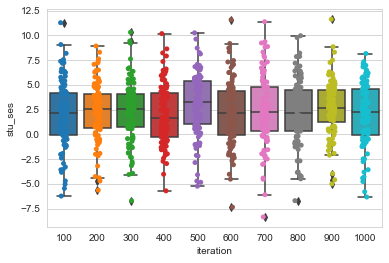

In [347]:
# stu_ses
sns.set_style('whitegrid')
ax= sns.boxplot(x="iteration",y="stu_ses",data=res)
ax = sns.stripplot(x="iteration", y="stu_ses",data=res)

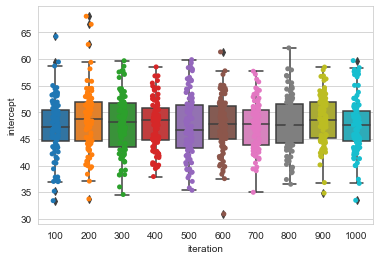

In [339]:
# inctercept
sns.set_style('whitegrid')
ax= sns.boxplot(x="iteration",y="intercept",data=res)
ax = sns.stripplot(x="iteration", y="intercept",data=res)

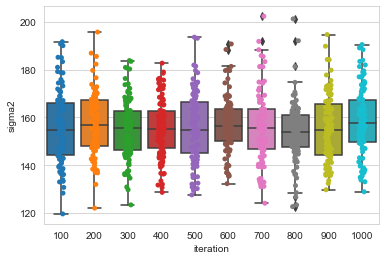

In [340]:
# sigma2
sns.set_style('whitegrid')
ax= sns.boxplot(x="iteration",y="sigma2",data=res)
ax = sns.stripplot(x="iteration", y="sigma2",data=res)

### Trace plots

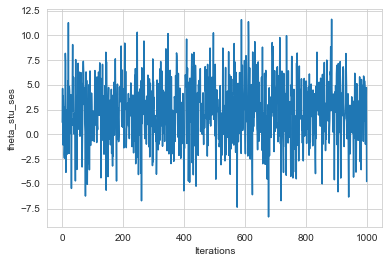

In [351]:
# theta_stu_ses
plt.plot(res['stu_ses'])
plt.xlabel("Iterations")
plt.ylabel("theta_stu_ses")
plt.show()

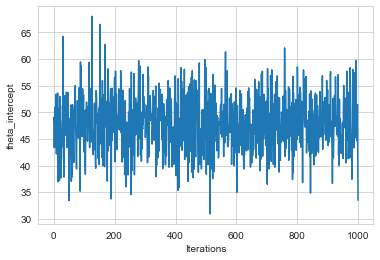

In [348]:
# intercept
plt.plot(res['intercept'])
plt.xlabel("Iterations")
plt.ylabel("theta_intercept")
plt.show()

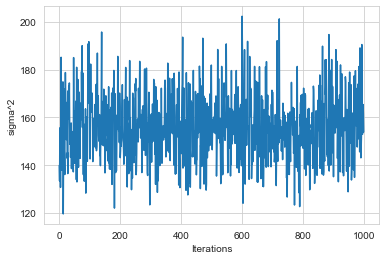

In [350]:
# sigma2
plt.plot(res['sigma2'])
plt.xlabel("Iterations")
plt.ylabel("sigma^2")
plt.show()

### Autocorrelation function

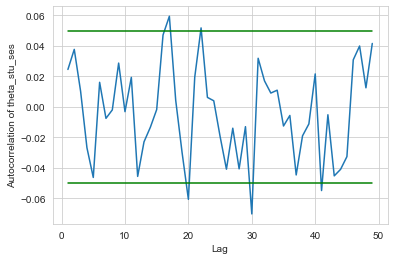

In [360]:
# theta_stu_ses
samples = res['stu_ses']
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of theta_stu_ses')
plt.show()

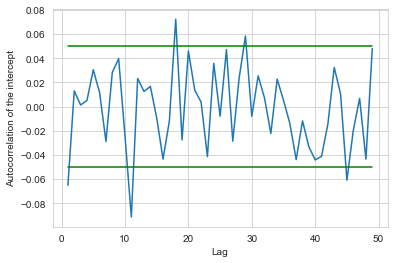

In [361]:
# intercept
samples = res['intercept']
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of the intercept')
plt.show()

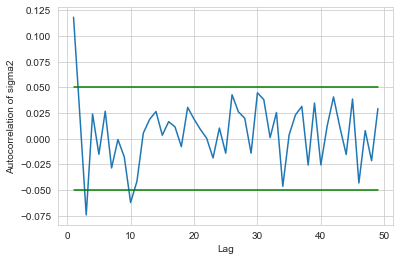

In [362]:
# sigma2
samples = res['sigma2']
num_samples = 50   # change you want to modify the number of lags

# computing the autocorrelations for different lags
lags = np.arange(1, num_samples)
autocorrs = [np.corrcoef(samples[:-lag], samples[lag:])[0, 1] for lag in lags]

# plotting the autocorrelations for different lags
plt.plot(lags, autocorrs)
plt.plot(lags, [-0.05]*len(lags), color = 'green')
plt.plot(lags, [0.05]*len(lags), color = 'green')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation of sigma2')
plt.show()

## Relationship between SES and math score

###  Posterior expectations of the 100 school-specific regression lines and average line

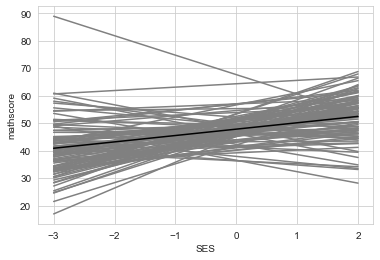

In [393]:
SES = np.arange(-3,3)

beta_est = np.mean(final_beta, axis = 0)
theta_est = np.mean(final_theta, axis = 0)

for i in range(len(beta_est)):
    plt.plot(SES, beta_est[i,0] + SES*beta_est[i,1], color = 'gray')

plt.plot(SES, theta_est[0] + SES*theta_est[1], color = 'black')

plt.xlabel('SES')
plt.ylabel('mathscore')
plt.show()

## Estimation of the results

In [391]:
beta_est = np.mean(final_beta, axis = 0)
print("Estimates of the beta: ", beta_est)
print()
j = 1033   # change with the code of the school you want the estimate of beta
pos = list(groups).index(j)
print("Estimate of beta for the school: ", beta_est[pos])
print()

theta_est = np.mean(final_theta, axis = 0)
print("Estimates of the theta: ", theta_est)
print()

SIG_est = np.mean(final_SIG, axis = 0)
print("Estimates of the upper sigma: ", SIG_est)
print()

sigma2_est = np.mean(final_sigma2, axis = 0)
print("Estimates of sigma2:", sigma2_est)

Estimates of the beta:  [[51.93404836  4.7690314 ]
 [45.8016332   7.01893814]
 [49.06698732  0.55382442]
 [46.92945995  4.21113484]
 [36.37324122 -1.6215987 ]
 [39.186739    1.00146262]
 [41.00443243  2.66697574]
 [47.22696276  6.31945705]
 [48.01899298  2.24289343]
 [41.25556891  0.65455533]
 [50.9801335   5.94030616]
 [50.58609256  5.36822629]
 [49.55152254 -0.45551858]
 [56.92705707  2.15472004]
 [53.44029552  7.66407081]
 [55.27097706  0.23935533]
 [37.89960709 -2.21044699]
 [48.45053309  6.67704241]
 [43.30712835  2.42171697]
 [46.1359075  -4.31783359]
 [49.4882389   1.99371704]
 [46.73856903  4.81831378]
 [47.3404533   7.59175034]
 [45.25742412  4.58708505]
 [45.49358637  4.23824843]
 [46.59744765  1.95487207]
 [45.1902204   9.40713964]
 [46.572717    5.49856805]
 [46.04584443  0.7311403 ]
 [48.81041433  2.81516058]
 [45.07808803  5.25731361]
 [49.54026466  1.65484814]
 [48.33115923  4.02178318]
 [46.05495854 -0.81386455]
 [50.66791519  7.84612872]
 [50.69524097  4.09909085]
 [48